In [204]:
import cv2
import os
import numpy as np
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Frame Extraction from videos

# RESIZE AND SCALE

# Faces Extraction with MTCNN

## Delete Noise in faces

## Select half the folders

## START RESNET 

In [15]:
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Create a new model for feature extraction (we use the output of the ResNet50 base model)
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

In [27]:
def preprocess_image(image_path):
    """
    Preprocess a single image frame for ResNet50.
    """
    # Read and resize the image
    image = cv2.imread(image_path)

    # Convert BGR to RGB (ResNet expects RGB images)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Normalize and preprocess the image (same normalization as ImageNet)
    image_preprocessed = preprocess_input(image_rgb)  # Normalization for ResNet

    # Expand dimensions to match model input shape (batch size 1)
    image_batch = np.expand_dims(image_preprocessed, axis=0)

    return image_batch

In [29]:
def extract_features_for_sequence(sequence_path, model):
    """
    Extract features for all frames in a video sequence folder.
    """
    features = []
    for frame_name in sorted(os.listdir(sequence_path)):  # Ensure frames are ordered
        frame_path = os.path.join(sequence_path, frame_name)
        if frame_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            # Preprocess the image for ResNet
            image_batch = preprocess_image(frame_path)
            
            # Extract feature vector using ResNet50
            feature_vector = model.predict(image_batch, verbose=0)
            
            # Flatten the feature vector to 1D
            features.append(feature_vector.flatten())

    return np.array(features)  # Return as NumPy array

In [31]:
def label_and_extract_features(base_folder, model):
    """
    Extract features and labels for all video sequences in the dataset.
    """
    data = []
    labels = []
    
    for label_name, label_value in {'real': 1, 'fake': 0}.items():
        folder_path = os.path.join(base_folder, label_name)
        if os.path.isdir(folder_path):
            for sequence_name in os.listdir(folder_path):
                sequence_path = os.path.join(folder_path, sequence_name)
                if os.path.isdir(sequence_path):  # Ensure it's a folder
                    # Extract features for this video sequence
                    features = extract_features_for_sequence(sequence_path, model)
                    data.append(features)  # Store the feature vectors
                    labels.append(label_value)  # Store the label for this sequence

    return data, labels

# Example: Label and extract features for the entire dataset
faces_train_folder = r"C:\Users\wiame\Documents\RECONNAISSANCE DES FORMES\PROJET\new_FACES"
data, labels = label_and_extract_features(faces_train_folder, feature_extractor)

# Example: Check shapes
print(f"Extracted features for {len(data)} sequences.")
print(f"Example sequence shape: {data[0].shape}")
print(f"Labels: {labels[:5]}")

Extracted features for 1906 sequences.
Example sequence shape: (21, 2048)
Labels: [1, 1, 1, 1, 1]


In [35]:
print(len(labels))

1906


In [208]:
print(data[54].shape)

(61, 2048)


In [57]:
# Invert the labels
labels_ = labels
labels = [1 - label for label in labels]

# Check the switched labels
print(f"Switched Labels: {labels[:10]}")

Switched Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [45]:
print(data[0])

[[0.         0.01019593 0.         ... 0.15548107 0.00454331 0.01489409]
 [0.         0.0069849  0.03151723 ... 0.6935246  0.04988791 0.04736813]
 [0.         0.04420053 0.         ... 0.6044611  0.03543784 1.1451368 ]
 ...
 [0.         0.         0.01888422 ... 0.52261317 0.14337139 0.2568845 ]
 [0.         0.         0.00144351 ... 0.6186473  0.05271327 0.07659001]
 [0.         0.20504765 0.00982271 ... 0.12995012 0.11378016 0.03949445]]


In [109]:
size_frames = []
for sequence in data:
    size_frames.append(sequence.shape[0])

print(np.min(size_frames), np.max(size_frames))

4 108


In [73]:
arr = np.array(size_frames)

In [97]:
num4 = len(arr[(arr > 0) & (arr<10)])
print(num4)

12


In [119]:
# Padding the sequences to ensure they all have the same length
max_length = np.max(size_frames) # Set this according to your data (e.g., max number of frames per sequence)
data_padded = pad_sequences(data, maxlen=max_length, dtype='float32', padding='post', truncating='post')

# Check shapes
print(f"Shape of padded data: {data_padded.shape}")
print(f"Shape of labels: {labels_array.shape}")

Shape of padded data: (1906, 108, 2048)
Shape of labels: (1906,)


In [121]:
size_frames = []
for sequence in data_padded:
    size_frames.append(sequence.shape[0])

print(np.min(size_frames), np.max(size_frames))

108 108


In [146]:
print(f"Shape of labels: {labels_array.shape}")

Shape of labels: (1906,)


In [154]:
X = np.array(data_padded)  # Assuming your data is in a NumPy array
Y = np.array(labels)  # Assuming your labels are in a NumPy array
print(Y.shape)

# Split the data into training and testing sets (e.g., 80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

(1906,)


In [156]:
X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [158]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_cv.shape, y_cv.shape)

(1334, 108, 2048) (1334,)
(286, 108, 2048) (286,)
(286, 108, 2048) (286,)


## APPLY LSTM

In [188]:
# Define the LSTM model
model = Sequential()

# Add a Masking layer to ignore padding values
model.add(Masking(mask_value=0.0, input_shape=(max_length, 2048)))  # Mask value is typically 0

# Add the LSTM layer
model.add(LSTM(64, return_sequences=False))  # 2048 is the feature vector size

# Add Dropout for regularization
model.add(Dropout(0.3))

# Add Dense layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))  # Binary classification (real vs fake)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [196]:
# Fit the model to the training data
history = model.fit(
    X_train,
    y_train,
    epochs=20, 
    batch_size=32,
    validation_data=(X_cv, y_cv),  # Cross-validation
    verbose=1 
)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9910 - loss: 0.0457 - val_accuracy: 0.9685 - val_loss: 0.0981
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9876 - loss: 0.0485 - val_accuracy: 0.9650 - val_loss: 0.1065
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9646 - loss: 0.1126 - val_accuracy: 0.9720 - val_loss: 0.0925
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9705 - loss: 0.0761 - val_accuracy: 0.9615 - val_loss: 0.1286
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9840 - loss: 0.0486 - val_accuracy: 0.9336 - val_loss: 0.1969
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9558 - loss: 0.1150 - val_accuracy: 0.9685 - val_loss: 0.0843
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.9853 - loss: 0.0559 - val_accuracy: 0.9650 - val_loss: 0.0991
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9905 - loss: 0.0336 - val_accuracy: 0.9

In [198]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9715 - loss: 0.1247
Test Loss: 0.11215542256832123
Test Accuracy: 0.9720279574394226


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


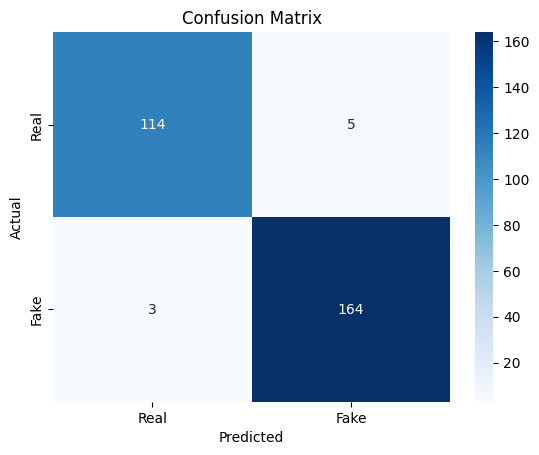

In [200]:

# Get predictions from the model
y_pred = model.predict(X_test)

# Convert predictions to binary (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [202]:
model.save('my_model.keras')